## EfficientNet architecture 

Pre-trained weights from: https://www.kaggle.com/hmendonca/efficientnet-pytorch-ignite and [Ignite examples](https://github.com/pytorch/ignite/tree/master/examples):
> Recently new ConvNets architectures have been proposed in "[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946.pdf)" paper. According to the paper, model's compound scaling starting from a 'good' baseline provides an network that achieves state-of-the-art on ImageNet, while being 8.4x smaller and 6.1x faster on inference than the best existing ConvNet.
![efficientnets](https://raw.githubusercontent.com/pytorch/ignite/c22609796031f5831f054036895696c7e4df07ce/examples/notebooks/assets/efficientnets.png)

This kernel borrowed some of its code from: https://www.kaggle.com/kageyama/fork-of-fastai-blindness-detection-resnet34 and https://www.kaggle.com/demonplus/fast-ai-starter-with-resnet-50 Many thanks to the authors!

If you liked it, please upvote and leave questions or any feedback below (for me and other kagglers learning).

Cheers!

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

from sklearn.metrics import confusion_matrix

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm, tqdm_notebook
import os, random
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle

!ls ../input/*

../input/aptos2019-blindness-detection:
sample_submission.csv  test.csv  test_images  train.csv  train_images

../input/efficientnet-pytorch:
efficientnet-b0-08094119.pth  efficientnet-b5-586e6cc6.pth
efficientnet-b1-dbc7070a.pth  efficientnet-b6-c76e70fd.pth
efficientnet-b2-27687264.pth  efficientnet-b7-dcc49843.pth
efficientnet-b3-c8376fa2.pth  efficientnet-pytorch
efficientnet-b4-e116e8b3.pth

../input/efficientnetb4-ignite-amp-clr-aptos19:
__notebook__.ipynb  __results___files		log
__output__.json     custom.css			submission.csv
__results__.html    efficientNet_0.1456262.pth


In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.basic_train import *
from fastai.vision.learner import *

fastai.__version__

'1.0.57'

In [3]:
# check if the kernel is running in interactive/edit/debug mode: https://www.kaggle.com/masterscrat/detect-if-notebook-is-running-interactively
def is_interactive():
   return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? False


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

In [5]:
# copy pretrained weights to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
model_path = '/tmp/.cache/torch/checkpoints/efficientNet.pth'
!cp ../input/efficientnet*/efficientNet_*.pth {model_path}

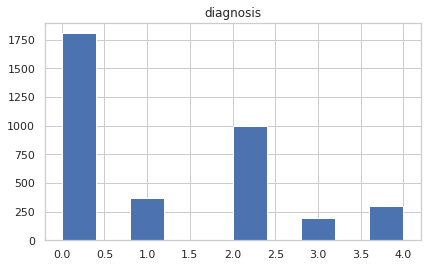

In [6]:
PATH = Path('../input/aptos2019-blindness-detection')

df_train = pd.read_csv(PATH/'train.csv')
df_test = pd.read_csv(PATH/'test.csv')

# if is_interactive():
#     df_train = df_train.sample(800)

_ = df_train.hist()

In [7]:
# create image data bunch
aptos19_stats = ([0.42, 0.22, 0.075], [0.27, 0.15, 0.081])
data = ImageDataBunch.from_df(df=df_train,
                              path=PATH, folder='train_images', suffix='.png',
                              valid_pct=0.1,
                              ds_tfms=get_transforms(flip_vert=True, max_warp=0.1, max_zoom=1.15, max_rotate=45.),
                              size=224,
                              bs=32, 
                              num_workers=os.cpu_count()
                             ).normalize(aptos19_stats)

In [8]:
# check classes
print(f'Classes: {data.classes}')

Classes: [0, 1, 2, 3, 4]


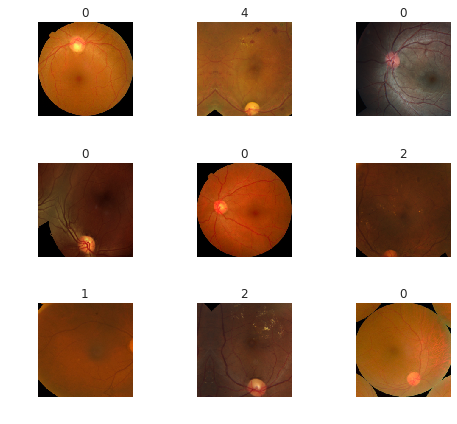

In [9]:
# show some sample images
data.show_batch(rows=3, figsize=(7,6))

## Define model

In [10]:
package_path = '../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)

from efficientnet_pytorch import EfficientNet

In [11]:
# FastAI adapators to retrain our model without lossing its old head ;)
def EfficientNetB4(pretrained=True):
    """Constructs a EfficientNet model for FastAI.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = EfficientNet.from_name('efficientnet-b4', override_params={'num_classes':5})

    if pretrained:
        model_state = torch.load(model_path)
        # load original weights apart from its head
        if '_fc.weight' in model_state.keys():
            model_state.pop('_fc.weight')
            model_state.pop('_fc.bias')
            res = model.load_state_dict(model_state, strict=False)
            assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
        else:
            # A basic remapping is required
            from collections import OrderedDict
            mapping = { i:o for i,o in zip(model_state.keys(), model.state_dict().keys()) }
            mapped_model_state = OrderedDict([
                (mapping[k], v) for k,v in model_state.items() if not mapping[k].startswith('_fc')
            ])
            res = model.load_state_dict(mapped_model_state, strict=False)
            print(res)
    return model

In [12]:
# create model
model = EfficientNetB4(pretrained=True)
# print model structure (hidden)
model

_IncompatibleKeys(missing_keys=['_fc.weight', '_fc.bias'], unexpected_keys=[])


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

## Loss and Learner

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [14]:
# from FastAI master
from torch.utils.data.sampler import WeightedRandomSampler

class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner, weights:torch.Tensor=None):
        super().__init__(learn)
        self.labels = self.learn.data.train_dl.dataset.y.items
        _, counts = np.unique(self.labels, return_counts=True)
        self.weights = (weights if weights is not None else
                        torch.DoubleTensor((1/counts)[self.labels]))

    def on_train_begin(self, **kwargs):
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(
            WeightedRandomSampler(self.weights, len(self.learn.data.train_dl.dataset)),
            self.learn.data.train_dl.batch_size,False)

In [15]:
# build model (using EfficientNet)
learn = Learner(data, model,
                loss_func=FocalLoss(),
                metrics=[accuracy, KappaScore(weights="quadratic")],
                callback_fns=[BnFreeze,
#                               OverSamplingCallback,
#                               partial(GradientClipping, clip=0.2),
                              partial(SaveModelCallback, monitor='kappa_score', name='best_kappa')]
               )
learn.split( lambda m: (model._conv_head,) )
learn.freeze()
learn.model_dir = '/tmp/'

## Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-03
Min loss divided by 10: 1.15E-03


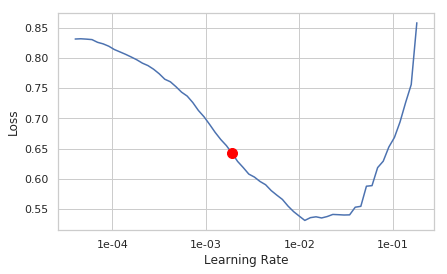

In [16]:
# train head first
learn.freeze()
learn.lr_find(start_lr=1e-5, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.282106,0.241771,0.784153,0.810928,09:07


Better model found at epoch 0 with kappa_score value: 0.8109280467033386.


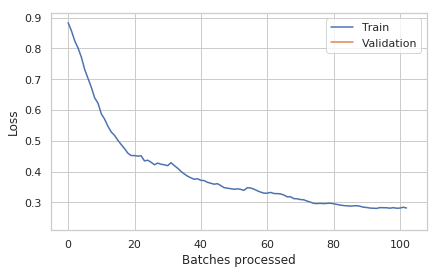

In [17]:
learn.fit_one_cycle(1, max_lr=3e-3, pct_start=0.1, div_factor=10, final_div=30, wd=5e-3, moms=(0.9, 0.8))
learn.save('stage-1')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.91E-04


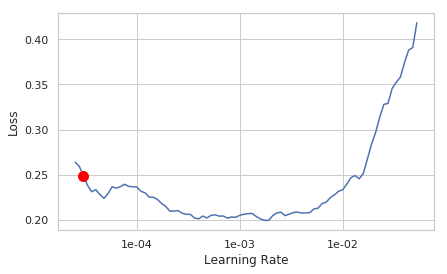

In [18]:
# unfreeze and search appropriate learning rate for full training
learn.unfreeze()
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.203015,0.237287,0.808743,0.862815,09:48
1,0.182833,0.253528,0.786885,0.879299,09:21
2,0.165972,0.203352,0.825137,0.866333,08:54


Better model found at epoch 0 with kappa_score value: 0.8628146052360535.
Better model found at epoch 1 with kappa_score value: 0.8792985081672668.


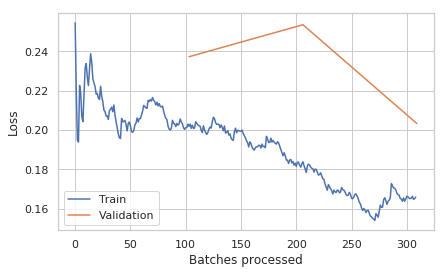

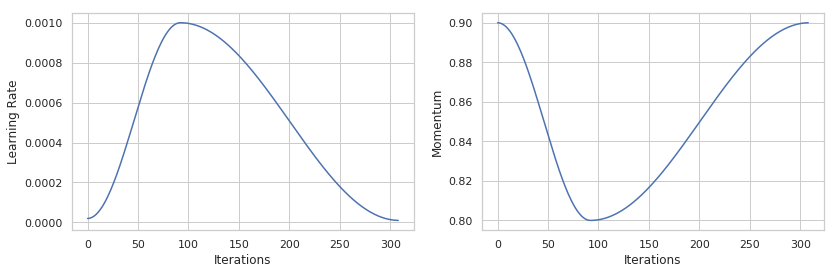

In [19]:
# train all layers
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-3), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))
learn.save('stage-2')
learn.recorder.plot_losses()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

In [20]:
# _ = learn.load('best_kappa')

# learn.lr_find(start_lr=slice(1e-7, 1e-6), end_lr=slice(1e-2, 1e-1), wd=1e-3)
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.176382,0.196530,0.816940,0.872901,08:53
1,0.157765,0.187075,0.830601,0.881923,08:59
2,0.135613,0.224320,0.822404,0.910072,09:01
3,0.130501,0.209721,0.836066,0.884820,08:19
4,0.118669,0.215767,0.836066,0.880758,08:10
5,0.101555,0.215721,0.819672,0.878971,08:06
6,0.089405,0.225789,0.838798,0.894146,08:01
7,0.086767,0.226344,0.814208,0.874250,08:02
8,0.083010,0.196555,0.833333,0.884121,08:05
9,0.066340,0.229426,0.836066,0.883139,08:09


Better model found at epoch 0 with kappa_score value: 0.8729006052017212.
Better model found at epoch 1 with kappa_score value: 0.8819231390953064.
Better model found at epoch 2 with kappa_score value: 0.9100721478462219.
Better model found at epoch 13 with kappa_score value: 0.928773820400238.


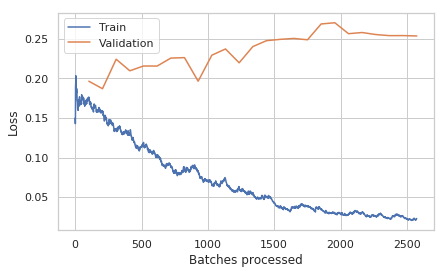

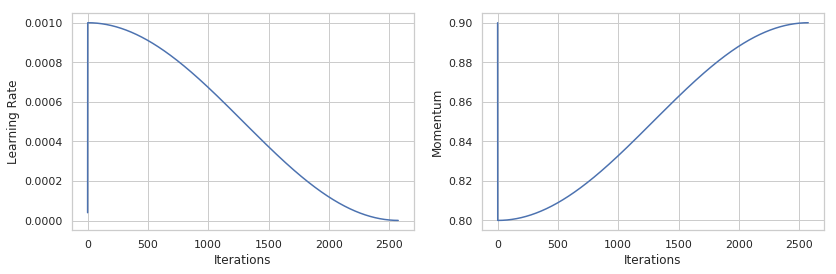

In [21]:
# train all layers
learn.fit_one_cycle(cyc_len=25, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
learn.save('stage-3')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

In [22]:
# learn.load('best_kappa')

# # retrain only head
# learn.freeze()
# learn.lr_find(start_lr=1e-7, end_lr=1e-1, wd=1e-2)
# learn.recorder.plot(suggestion=True)

In [23]:
# learn.fit_one_cycle(6, max_lr=1e-3, div_factor=100, wd=1e-2)
# learn.save('stage-4')

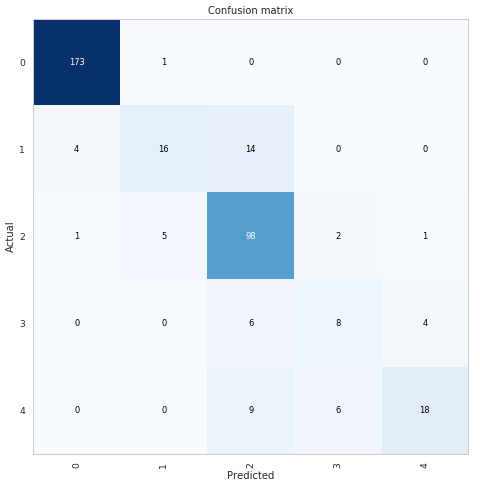

In [24]:
learn.load('best_kappa')

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [25]:
# interp.plot_top_losses(5, figsize=(15,11))  ## TODO: fix loss function reduction topk

## TTA and submission

In [26]:
# remove zoom from FastAI TTA
tta_params = {'beta':0.12, 'scale':1.0}

In [27]:
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [28]:
learn.data.add_test(ImageList.from_df(
    sample_df, PATH,
    folder='test_images',
    suffix='.png'
))

In [29]:
preds,y = learn.TTA(ds_type=DatasetType.Test, **tta_params)

In [30]:
sample_df.diagnosis = preds.argmax(1)
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


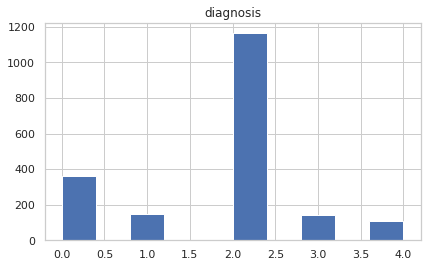

In [31]:
sample_df.to_csv('submission.csv',index=False)
_ = sample_df.hist()

In [32]:
#move models back to root folder
!mv {learn.model_dir}/*.pth .
os.listdir()

['__output__.json',
 'stage-2.pth',
 '__notebook__.ipynb',
 'stage-1.pth',
 'stage-3.pth',
 'tmp.pth',
 'submission.csv',
 'best_kappa.pth']